In [3]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
gpu = gpus[0]

tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.compat.v1.disable_eager_execution()

In [5]:
"""
this technique will allow to locate specific objects in the image
helpful for debugging
class activation map (CAM) visualization
it produces heatmap of class activation over input images
2d grid of scores associated with specific output class - computed for every location
it can help finding cat like parts in result where class is cat


Grad-CAM Visual Explaination from Deep Networks via Gradient-based Localization
"""

from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [6]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [7]:
img_path = 'elephant.jpg'

img = image.load_img(img_path, target_size=(224,224))
img = image.img_to_array(img)
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


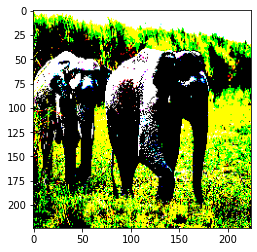

In [22]:
plt.imshow(img)

In [9]:
pred = model.predict(x)

In [11]:
print("Predictions: ", decode_predictions(pred, top=3)[0])

Predictions:  [('n01871265', 'tusker', 0.5295437), ('n02504013', 'Indian_elephant', 0.37518126), ('n02504458', 'African_elephant', 0.09527302)]


In [12]:
np.argmax(pred)

101

In [14]:
import keras.backend as K

In [15]:
tusker_op = model.output[:,386]
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(tusker_op, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_op_value = iterate([x])

for i in range(512):
    conv_layer_op_value[:,:,i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_op_value, axis=-1)

In [17]:
import matplotlib.pyplot as plt

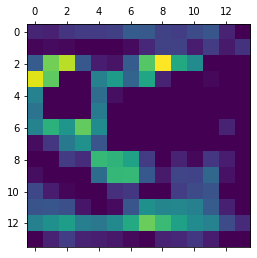

In [18]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [23]:
import cv2

In [24]:
img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('elephant_cam.jpg', superimposed_img)

True

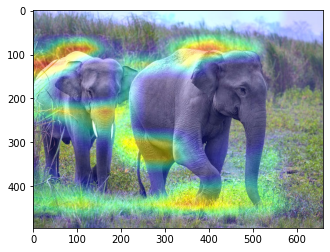

In [27]:
img2 = cv2.imread('elephant_cam.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.show()

# For Cat

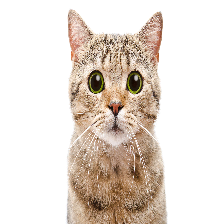

In [28]:
img_path = 'cat.jpg'

img = image.load_img(img_path, target_size=(224,224))
img

In [29]:
img = image.img_to_array(img)
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

In [30]:
pred = model.predict(x)
print("Predictions: ", decode_predictions(pred, top=3)[0])

Predictions:  [('n02124075', 'Egyptian_cat', 0.7110379), ('n02123045', 'tabby', 0.18609853), ('n02123159', 'tiger_cat', 0.07470265)]


In [31]:
np.argmax(pred)

285

In [32]:
cat_op = model.output[:,285]
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(cat_op, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_op_value = iterate([x])

for i in range(512):
    conv_layer_op_value[:,:,i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_op_value, axis=-1)

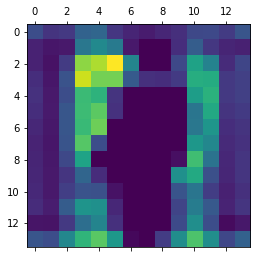

In [33]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [34]:
img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('cat_cam.jpg', superimposed_img)

True

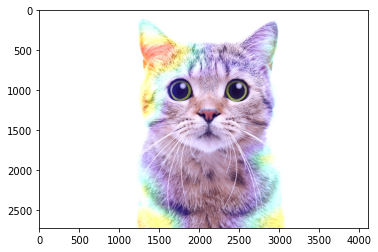

In [35]:
img2 = cv2.imread('cat_cam.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.show()

# For All

In [58]:
def generate_heatmap(img_path):
    # READ IMAGE
    img = image.load_img(img_path, target_size=(224,224))
    orig_img = img.copy()
    
    # PREPROCESS IMAGE
    img = image.img_to_array(img)
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)

    # RUN MODEL TO FIND PREDICTIONS
    pred = model.predict(x)
    print("Predictions: ", decode_predictions(pred, top=3)[0])
    index = np.argmax(pred)

    # FIND THE OUTPUT LAYER FOR PARTICULAR IMAGE CLASS
    cat_op = model.output[:,index]
    last_conv_layer = model.get_layer('block5_conv3')

    # GRADIENT DESCENT TO FIND HEATMAP
    grads = K.gradients(cat_op, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0,1,2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_op_value = iterate([x])

    for i in range(512):
        conv_layer_op_value[:,:,i] *= pooled_grads_value[i]

    # PROCESSING THE HEATMAP
    heatmap = np.mean(conv_layer_op_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)
    plt.show()

    # READING IMAGE TO APPLY HEATMAP
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite(f'{img_path}_cam.jpg', superimposed_img)

    # SHOWING FINAL IMAGE WITH HEATMAP
    img2 = cv2.imread(f'{img_path}_cam.jpg')
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    
    plt.imshow(orig_img)
    plt.show()
    
    plt.imshow(img2)
    plt.show()

Predictions:  [('n02124075', 'Egyptian_cat', 0.7110379), ('n02123045', 'tabby', 0.18609853), ('n02123159', 'tiger_cat', 0.07470265)]


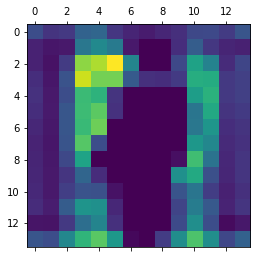

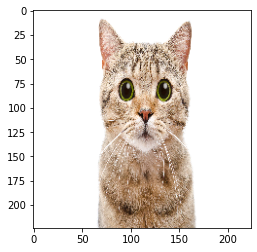

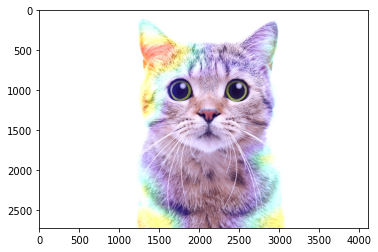

In [59]:
img_path = 'cat.jpg'
generate_heatmap(img_path)

Predictions:  [('n02110958', 'pug', 0.97965634), ('n02108422', 'bull_mastiff', 0.014410978), ('n02112706', 'Brabancon_griffon', 0.0019565658)]


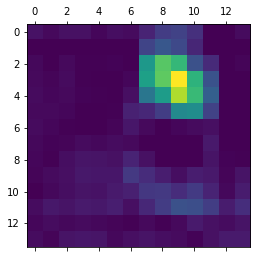

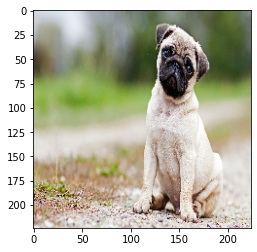

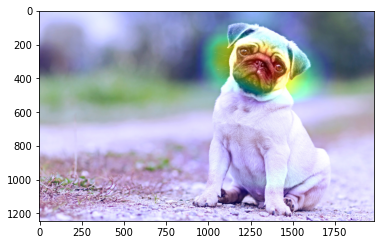

In [60]:
img_path = 'pug.jpg'
generate_heatmap(img_path)

Predictions:  [('n02493509', 'titi', 0.64861584), ('n02494079', 'squirrel_monkey', 0.30007702), ('n02493793', 'spider_monkey', 0.03794528)]


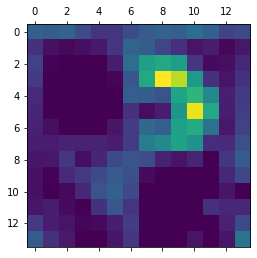

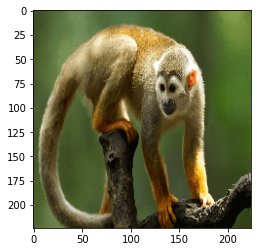

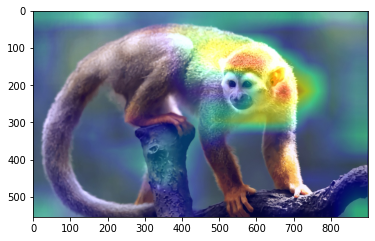

In [61]:
img_path = 'sq_monkey.jpg'
generate_heatmap(img_path)